In [18]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.0


In [19]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [20]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio, validation_ratio):
    test_ratio = 1 - train_ratio - validation_ratio
    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        images = os.listdir(category_path)
        random.shuffle(images)
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        val_count = int(total_images * validation_ratio)
        train_images = images[:train_count]
        val_images = images[train_count:train_count + val_count]
        test_images = images[train_count + val_count:]

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category, image))
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, category, image))
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, category, image))

In [21]:
def create_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size,
                                                        batch_size=batch_size, class_mode='categorical')
    val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=target_size,
                                                         batch_size=batch_size, class_mode='categorical')
    test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=target_size,
                                                          batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator

In [22]:
def cbam_block(inputs, reduction=16):
    # Channel Attention
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    shared_dense = layers.Dense(inputs.shape[-1] // reduction, activation='relu')
    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    channel = layers.Add()([avg_out, max_out])
    channel = layers.Dense(inputs.shape[-1], activation='sigmoid')(channel)
    channel = layers.Reshape((1, 1, inputs.shape[-1]))(channel)
    x = layers.Multiply()([inputs, channel])
    # Spatial Attention
    avg_spatial = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_spatial, max_spatial])
    spatial = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, spatial])

In [9]:
def crm_block(x):
    edge = tf.image.sobel_edges(x)
    edge_mean = tf.reduce_mean(edge, axis=-1, keepdims=True)
    stat_mean = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    stat_mean = tf.tile(stat_mean, [1, x.shape[1], x.shape[2], 1])
    x_cat = layers.Concatenate(axis=-1)([edge_mean[..., 0], stat_mean])
    attention = layers.Conv2D(x.shape[-1], (1, 1), activation='sigmoid')(x_cat)
    return layers.Multiply()([x, attention])

In [10]:
def build_model(input_shape=(224, 224, 3), num_classes=4):
    base = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False
    x = base.output
    x = cbam_block(x)
    x = crm_block(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=outputs)
    return model

In [11]:
def train_model(model, train_gen, val_gen, epochs=30):
    model.compile(optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    callbacks = [
        EarlyStopping(patience=8, restore_best_weights=True),
        ReduceLROnPlateau(patience=4, factor=0.5),
        ModelCheckpoint("EyeNet_Latest_Model.h5", save_best_only=True)
    ]
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)

In [12]:
def fine_tune_model(model, train_gen, val_gen, epochs=10):
    model.trainable = True
    model.compile(optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
                  loss=SigmoidFocalCrossEntropy(),
                  metrics=['accuracy'])
    return model.fit(train_gen, validation_data=val_gen, epochs=epochs)

In [13]:
def evaluate_model(model, test_gen):
    loss, acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {acc * 100:.2f}%")
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues'); plt.title("Confusion Matrix"); plt.colorbar()
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

In [16]:
def main():
    set_seed()
    base_dir = r'C:\Users\User\Desktop\dataset_split'
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    train_gen, val_gen, test_gen = create_generators(train_dir, val_dir, test_dir)
    model = build_model()
    train_model(model, train_gen, val_gen)
    fine_tune_model(model, train_gen, val_gen)
    evaluate_model(model, test_gen)
    model.save("EyeNet_Model.h5")
    print("Model saved.")

Found 7490 images belonging to 4 classes.
Found 1499 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Epoch 1/30
235/235 [==============================] - 75s 309ms/step - loss: 0.2134 - accuracy: 0.4270 - val_loss: 0.1493 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 2/30
235/235 [==============================] - 43s 182ms/step - loss: 0.1518 - accuracy: 0.6622 - val_loss: 0.1179 - val_accuracy: 0.7498 - lr: 1.0000e-04
Epoch 3/30
235/235 [==============================] - 44s 186ms/step - loss: 0.1258 - accuracy: 0.7382 - val_loss: 0.1043 - val_accuracy: 0.7932 - lr: 1.0000e-04
Epoch 4/30
235/235 [==============================] - 40s 168ms/step - loss: 0.1139 - accuracy: 0.7678 - val_loss: 0.0947 - val_accuracy: 0.8192 - lr: 1.0000e-04
Epoch 5/30
235/235 [==============================] - 40s 169ms/step - loss: 0.1021 - accuracy: 0.7999 - val_loss: 0.0863 - val_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 6/30
235/235 [==============================] - 40s 169ms/

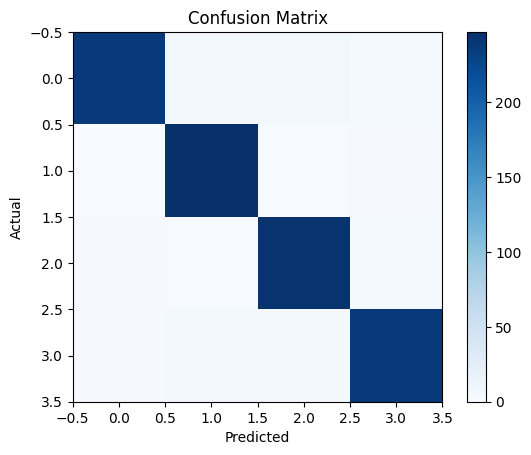

Model saved.


In [23]:
if __name__ == '__main__':
    main()